<p><b>Objective</b>: To gather and analyze data on BKK tram, bus and metro routes, focusing on Wheelchair accessibility. Specifically, using data from the BKK API, determine what share of the BKK network is accessible to people in wheelchairs. Given a list of wheelchair accessible stations, generate data on which stations can be reached from those starting points. <br><br>
<b>Key Concepts and tools</b>: Data from APIs, requests, data analysis</p>

In [1]:
import requests
import json
import pandas as pd

def fetch_and_save_data():
    # Define the URL and parameters
    url = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/stops-for-location'
    # Define the parameters in a dictionary
    params = {
        'lat': 47.4973131430789,
        'lon': 19.064639534671457,
        'latSpan': 0.013365429598373169,
        'lonSpan': 0.032126676908724505,
        'radius': 100,
        'minResult': 5,
        'appVersion': '1.1.abc',
        'version': 2,
        'includeReferences': 'true',
        'key': '3dfc5343-58ca-4976-8cfb-adbea8b9d791'
    }

    # Define the headers
    headers = {
        'accept': 'application/json'
    }

    # Make the GET request
    response = requests.get(url, params=params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        
        # Filter the stops where "wheelchairBoarding": true
        all_stops = [stop for stop in data['data']['list']]
        
        # Convert the filtered data to a DataFrame
        df = pd.DataFrame(all_stops)
        
        # Save the DataFrame to a CSV file
        filename = 'all_stops.csv'
        df.to_csv(filename, index=False)
        
        print(f"All stops are saved to {filename}")
    else:
        # Print the error code and response text if the request failed
        print(f"Error: {response.status_code}, {response.text}")

# Call the function to fetch and save the data

In [2]:
fetch_and_save_data()

All stops are saved to all_stops.csv


In [3]:
import pandas as pd
import folium
import os
import webbrowser
#Draws a map that contains all stops that can be reached from given location.
class Map():
    def __init__(self, df):
        # Create a map centered around the first stop
        # atts and tiles are needed to plot 
        attr = ('&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> ''contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>')
        tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"
        m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=13, tiles=tiles, attr=attr)

        # Add the stops to the map
        for idx, row in df.iterrows():
            folium.Marker(
                location=[row['lat'], row['lon']],
                popup=(
                    f"{row['name']}<br>"
                    f"{row['stopColorType']}"
                    # f"Locality: {row['localityName']}<br>" # IF you want the map to show the district num
                ),
                icon=folium.Icon(color='blue' if row['wheelchairBoarding'] else 'red')
            ).add_to(m)

        # Define the filename and save the map to an HTML file
        filename = 'map.html'
        m.save(filename)

        print("Map has been saved to", filename)
        # Open the saved HTML file in the default web browser
        webbrowser.open('file://' + os.path.realpath(filename))


In [4]:
import pandas as pd

class Stops:
    def __init__(self, filename) -> None:
        self.data = pd.read_csv(filename)

    def all_stops(self):
        return self.data
    
    def wheelchair_accessible(self):
        # Filter the DataFrame to only include stops that are wheelchair accessible
        return self.data[self.data['wheelchairBoarding'] == True]
    
    def by_district(self, district):
        return self.data[self.data['localityName'] // 10 == district  // 10]
    
    def by_transport(self, types):
        return self.data[self.data['stopColorType'] == types]


In [5]:
stops = Stops('all_stops.csv')
district_map = {101: 'I', 102: 'II', 103: 'III', 104: 'IV', 105: 'V', 106: 'VI', 107: 'VII', 108: 'VIII', 109: 'IX', 110: 'X', 111: 'XI', \
112: 'XII', 113: 'XIII', 114: 'XIV', 115: 'XV', 116: 'XVI', 117: 'XVII', 118: 'XVIII', 119: 'XIX', 120: 'XXI', 121: 'XXII', 122: 'XXIII'}

In [6]:
#Overall: 538 stops
print(f"Overall: {len(stops.all_stops())} stops")

#Wheelchair Accessible: 375 stops
print(f"Wheelchair Accessible: {len(stops.wheelchair_accessible())} stops")

#V district: 93 stops
district = 105_5 #Only first 3-digits matter but input 4-digit number please
print(f"{district_map[district // 10]} district: {len(stops.by_district(district))} stops")

#BUS: 171 stops
type = ['OTHER', 'TRAM', 'NIGHTBUS', 'BUS', 'M4', 'TROLLEYBUS', 'TROLLEYBUS-BUS', 'M2', 'M3', 'H5', 'M1', 'TRAM-TROLLEYBUS-BUS', 'TRAM-BUS']
print(f"{type[3]}: {len(stops.by_transport(type[3]))} stops")
# Map(stops.all_stops())
# Map(stops.by_district(district))
# Map(stops.wheelchair_accessible(stops.by_transport(type[3])))

Overall: 545 stops
Wheelchair Accessible: 380 stops
V district: 93 stops
BUS: 175 stops


In [7]:
import matplotlib.pyplot as plt
class Stats:
    def __init__(self, filename) -> None:
        self.data = pd.read_csv(filename)
    
    def wheelchair_accessible(self):
        return self.data[self.data['wheelchairBoarding'] == True]
    
    def stat_by_district(self):
        district_map = {101: 'I', 102: 'II', 103: 'III', 104: 'IV', 105: 'V', 106: 'VI', 107: 'VII', 108: 'VIII', 109: 'IX', 110: 'X', 111: 'XI', \
        112: 'XII', 113: 'XIII', 114: 'XIV', 115: 'XV', 116: 'XVI', 117: 'XVII', 118: 'XVIII', 119: 'XIX', 120: 'XXI', 121: 'XXII', 122: 'XXIII'}
        res = {}
        # Initialize counts for each district to zero
        for district_num in district_map:
            res[district_map[district_num]] = 0
        # Iterate through each localityName and increment counts for corresponding districts
        for district_num in self.data['localityName']:
            district_roman = district_map[district_num // 10]
            res[district_roman] += 1

        return res
    
    def plot_graph(self, data):
        district_counts_filtered = {district: count for district, count in data.items() if count != 0}
        plt.figure(figsize=(10, 6))
        plt.bar(district_counts_filtered.keys(), district_counts_filtered.values(), color='skyblue')
        plt.xlabel('District')
        plt.ylabel('Number of Stops')
        plt.title('Distribution of Stops by District')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

    def plot_double_graph(self, data1, data2):
        data1 = {district: count for district, count in data1.items() if count != 0}
        data2 = {district: count for district, count in data2.items() if count != 0}
        districts = list(set(list(data1.keys()) + list(data2.keys())))
        # Initialize lists to store counts for each type of stop
        type1_stops = []
        type2_stops = []
        for district in districts:
            type1_stops.append(data1.get(district, 0))
            type2_stops.append(data2.get(district, 0))
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        plt.bar(districts, type1_stops, bar_width, color='blue', label='Wheelchair Accessible')
        plt.bar([x + bar_width for x in range(len(districts))], type2_stops, bar_width, color='red', label='Not Wheelchair Accessible')
        plt.xlabel('District')
        plt.ylabel('Number of Stops')
        plt.xticks([x + bar_width / 2 for x in range(len(districts))], districts)  # Set x-axis ticks at the center of each bar group
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

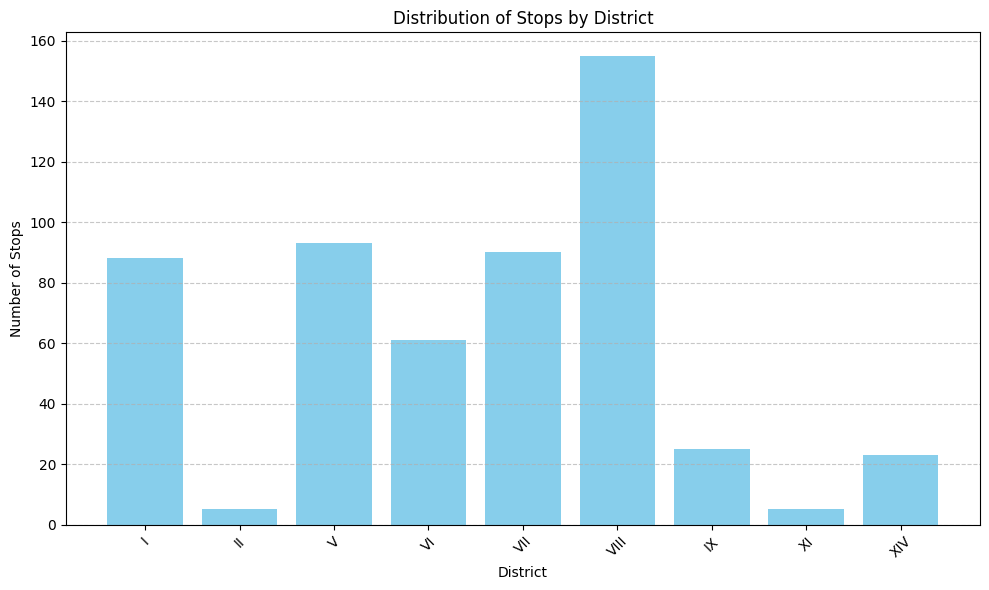

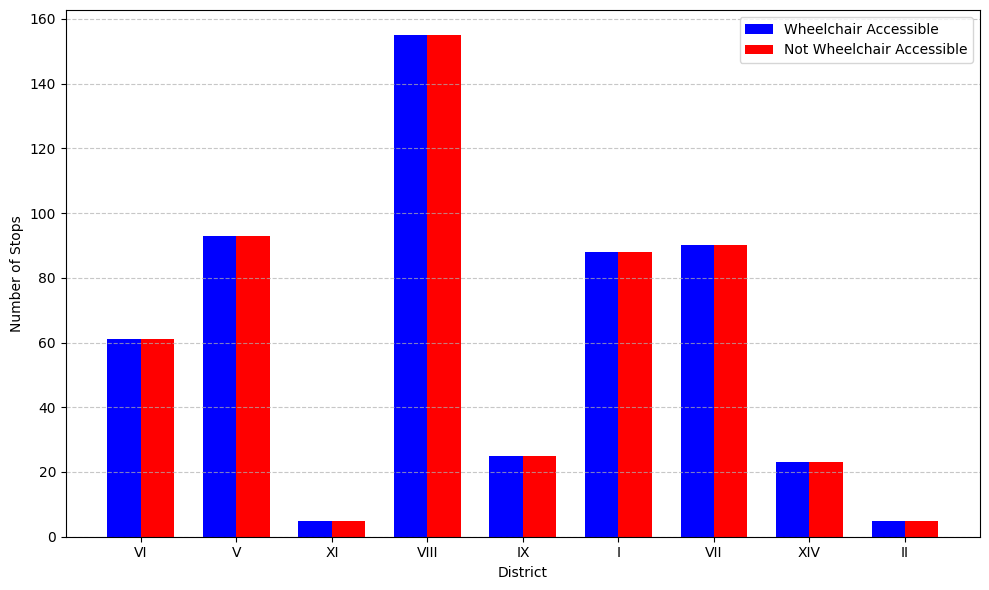

In [8]:
go = Stats('all_stops.csv')
go.plot_graph(go.stat_by_district())
go.plot_double_graph(go.stat_by_district(), go.stat_by_district())